In [1]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform, z_score_normalization
from project.utils import collate_fn, plot_mri_slice, plot_all_slices, plot_all_slices_from_array, collatev2
import winsound
from torchvision.models import resnet18, ResNet18_Weights
from project.utils import memcheck, compute_statistics
from project.evaluation import isa_rpn_metric

In [2]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
dte = dtt.now().strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('andy')
fh = logging.FileHandler(f'logs/{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

dte

'Nov_11_2024_223109'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Config for fitter

In [4]:
from project.model import RPN

config = {
    'model': RPN(
        input_dim=512,
        output_dim=4,
        image_size=300,
        nh=4,
        pretrained=True
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 5,
    'loss': nn.SmoothL1Loss(),
    # 'loss': nn.MSELoss(),
    # 'loss': nn.L1Loss(),
    'lr': 0.0001
}

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


#### Load Pretrained Embedder

#### Load RPN Weights

### Load dataset

In [5]:
ds = Dataset()

data = pd.read_csv('targets.csv')
data.shape

(7986, 7)

In [6]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
data

,mri,masks,target,has_microbleed_case,has_microbleed_slice,cohort,max_value
0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,1,1,1,928.405273
1,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,9,1,1,1,928.405273
2,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,11,1,1,1,928.405273
3,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,12,1,1,1,928.405273
4,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,15,1,1,1,928.405273
...,...,...,...,...,...,...,...
359,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,25,1,1,3,241.000000
360,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,26,1,1,3,241.000000
361,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,24,1,1,3,448.000000
362,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,25,1,1,3,448.000000


### `DataLoader` Generator

In [7]:
def iqr(data, col):
    q3 = data[col].quantile(0.75)
    q1 = data[col].quantile(0.25)
    iqr = q3-q1
    new = data[(data[col] < (q3 + 1.5*iqr)) & (data[col] > (q1 - 1.5*iqr))]
    return new

In [8]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 batch_size,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None
                ):
    data = data[data.cohort == cohort]
    # data = iqr(data, 'max_value')
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.mri.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.mri.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.mri.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    train_loader = DataLoader(
        train_set,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=collatev2
    )
    val_loader = DataLoader(
        val_set,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=collatev2
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_loader, val_loader

### Fitter

In [ ]:
from project import Fitter

class RPNFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        evaluation_metric = {
            'iou_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': []
        }
        counter = 0
        for batch in train_loader:
            # self.log('----------------- BATCH -----------------')
            Y = []
            T = []
            for slices, masks, target, case in batch:
                x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                masks = masks.squeeze(1).float().to(self.device)/300
                y = self.model(x, target)

                iou_score, precision_score, recall_score, f1_score = isa_rpn_metric(image_size=300, target_bbox=masks[target], predicted_bbox=y)
                evaluation_metric['iou_score'].append(iou_score)
                evaluation_metric['precision_score'].append(precision_score)
                evaluation_metric['recall_score'].append(recall_score)
                evaluation_metric['f1_score'].append(f1_score)
                Y.append(y)
                T.append(masks[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            # if counter % len(batch) == 0:
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            
            loss_history.append(losses.detach().cpu().numpy())
        
        self.log(f'\nTraining Evaluation Metric:')
        self.log(f"Avg IOU: {sum(evaluation_metric['iou_score']) / len(evaluation_metric['iou_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        
        return loss_history, evaluation_metric
    def validation(self, val_loader):
        self.model.eval()
        loss_history = []
        evaluation_metric = {
            'iou_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': []
        }
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                    masks = masks.squeeze(1).float().to(self.device)/300
                    y = self.model(x, target)
                    iou_score, precision_score, recall_score, f1_score = isa_rpn_metric(image_size=300, target_bbox=masks[target], predicted_bbox=y)
                    evaluation_metric['iou_score'].append(iou_score)
                    evaluation_metric['precision_score'].append(precision_score)
                    evaluation_metric['recall_score'].append(recall_score)
                    evaluation_metric['f1_score'].append(f1_score)
                    Y.append(y)
                    T.append(masks[target])
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        self.log(f'\nValidation Evaluation Metric:')
        self.log(f"Avg IOU: {sum(evaluation_metric['iou_score']) / len(evaluation_metric['iou_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        return loss_history, evaluation_metric
                

In [10]:
fitter = RPNFitter(config, logger=logger)

### Training

In [11]:
tl, vl = make_loaders(
    data=data,
    cohort=1,
    batch_size=2
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 7), (9, 7))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)



In [12]:
thist, vhist, tmhist, vmhist = fitter.fit(tl, vl)

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


KeyboardInterrupt: 

In [ ]:
winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

<Axes: >

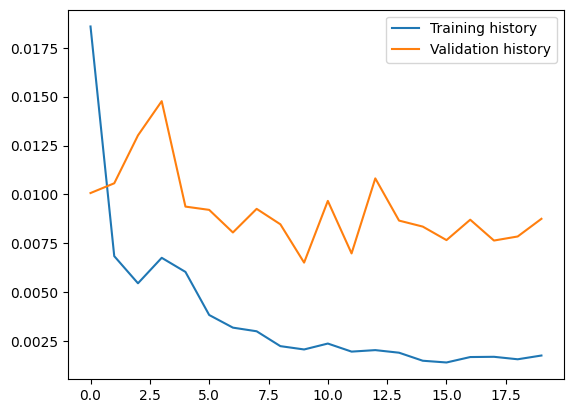

In [ ]:
import seaborn as sns
import numpy as np

th = torch.tensor(np.array(thist))
vh = torch.tensor(np.array(vhist))
# print(th.shape)
sns.lineplot(th.mean(1), label='Training history')
sns.lineplot(vh.mean(1), label='Validation history')

### Save the weights

# Summary

Trained using bboxes that have a padding of 50 or more. Improved the model but it seems like cheating to get the metrics up

Decision for which embedder to use is also decided here

TODO:
- multiple bounding box proposal
- start with vit optimizations

# Trial

In [ ]:
model = fitter.model

In [ ]:
sample = next(enumerate(vl))

In [ ]:
slices, masks, target, case = sample[1][1]

In [ ]:
x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(device)
T = masks.squeeze(1).float().to(device)

In [ ]:
y = model(x, target)

In [ ]:
y

tensor([[0.2392, 0.3567, 0.4803, 0.6231]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [ ]:
fitter.loss(y, T[target])

tensor(90.4815, device='cuda:0', grad_fn=<SmoothL1LossBackward0>)

In [ ]:
masks[target]

tensor([[[ 39.8438,  82.0312, 100.7812, 142.9688]]], dtype=torch.float64)

In [ ]:
y

tensor([[0.2392, 0.3567, 0.4803, 0.6231]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [ ]:
bbox = masks[target].squeeze().cpu().long()

In [ ]:
y = (y*300).squeeze().detach().cpu().long()

In [ ]:
bbox, y

(tensor([ 39,  82, 100, 142]), tensor([ 71, 107, 144, 186]))

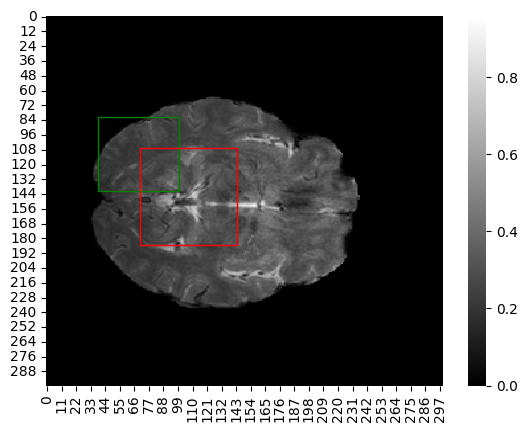

In [ ]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

ax = sns.heatmap(x[target][0].squeeze().cpu(), cmap='gray')

truth = patches.Rectangle(
    (bbox[0], bbox[1]),
    bbox[2] - bbox[0],
    bbox[3] - bbox[1],
    linewidth=1, edgecolor='g', facecolor='none'
)

pred = patches.Rectangle(
    (y[0], y[1]),
    y[2] - y[0],
    y[3] - y[1],
    linewidth=1, edgecolor='r', facecolor='none'
)

ax.add_patch(truth)
ax.add_patch(pred)
plt.show()